In [42]:
import xarray as xr
base_dir = f'/mnt/lustre/koa/class/atmo449_class/students/team_1_flood_risk/'
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

In [19]:
hawaii_lat_bound, hawaii_lon_bound = slice(18, 23), slice(-161, -154)

In [24]:
ds_gcm = xr.open_dataset(f"{base_dir}/raw_data/GFDL/GFDL_CM4C192_pr_hawaii_2007_2014.nc")
ds_gcm = ds_gcm.assign_coords(lon=(ds_gcm.lon + 180) % 360 - 180).sel(lat=hawaii_lat_bound, lon=hawaii_lon_bound)

In [60]:
annual_precip_rate_mean = ds_gcm.mean(dim='time')['pr'].to_numpy()
annual_precip_rate_std = ds_gcm.std(dim='time')['pr'].to_numpy()
annual_precip_rate_98 = ds_gcm.quantile(dim='time', q=0.98)['pr'].to_numpy()

In [135]:
dry_months, wet_months = [5,6,7,8,9,10], [1,2,3,4,11,12]

In [137]:
dry_precip_rate_mean = ds_gcm.sel(time=ds_gcm.time.dt.month.isin(dry_months)).mean(dim='time')['pr'].to_numpy()
dry_precip_rate_std = ds_gcm.sel(time=ds_gcm.time.dt.month.isin(dry_months)).std(dim='time')['pr'].to_numpy()
dry_precip_rate_98 = ds_gcm.sel(time=ds_gcm.time.dt.month.isin(dry_months)).quantile(dim='time', q=0.98)['pr'].to_numpy()

wet_precip_rate_mean = ds_gcm.sel(time=ds_gcm.time.dt.month.isin(wet_months)).mean(dim='time')['pr'].to_numpy()
wet_precip_rate_std = ds_gcm.sel(time=ds_gcm.time.dt.month.isin(wet_months)).std(dim='time')['pr'].to_numpy()
wet_precip_rate_98 = ds_gcm.sel(time=ds_gcm.time.dt.month.isin(wet_months)).quantile(dim='time', q=0.98)['pr'].to_numpy()

In [138]:
accum_precip_3_hourly = ds_gcm * (3 / 24)# convert rate (mm/day) to accumulation (mm over 3-hour)
accum_precip_daily = accum_precip_3_hourly.resample(time='1D').sum()

annual_rainy_day_freq = (accum_precip_daily > 1).mean(dim='time')['pr'].to_numpy()
dry_rainy_day_freq = (accum_precip_daily.sel(time=accum_precip_daily.time.dt.month.isin(dry_months)) > 1).mean(dim='time')['pr'].to_numpy()
wet_rainy_day_freq = (accum_precip_daily.sel(time=accum_precip_daily.time.dt.month.isin(wet_months)) > 1).mean(dim='time')['pr'].to_numpy()

In [221]:
def plot_contourf(lat, lon, data, levels, cmap, ax, cbar=True, cbar_label=''):
    cf = ax.contourf(lon, lat, data, cmap=cmap, levels=levels, extend='both', transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(lon, lat, data, colors='k', linewidths=1, levels=levels[::2],
                    transform=ccrs.PlateCarree())
    # add contour labels
    lb = plt.clabel(cs, fontsize=14, inline=False, fmt='%0.1f');
    if cbar:
        cb = plt.colorbar(cf, shrink=0.6)
        cb.ax.set_title('', fontsize=3.5)
        cb.set_label(cbar_label, fontsize=10)
        cb.ax.tick_params(labelsize=10)

def geo_ylabel(ax, label, **kwargs):
    """
    Adds a y-axis-like label to a GeoAxes (or regular Axes).
    
    Parameters
    ----------
    ax : matplotlib Axes or GeoAxes
        Axis to which the label will be attached.
    label : str
        The label text.
    **kwargs : dict
        Extra text properties (e.g., fontsize, color, fontweight, etc.)
    """
    bbox = ax.get_position()
    fig = ax.figure

    # find vertical center of the axes
    y_center = (bbox.y0 + bbox.y1) / 2

    # place label just outside the left edge
    fig.text(
        bbox.x0 - 0.015,  # horizontal offset (tweak as needed)
        y_center,
        label,
        va='center', ha='right',
        rotation='vertical',
        **kwargs
    )


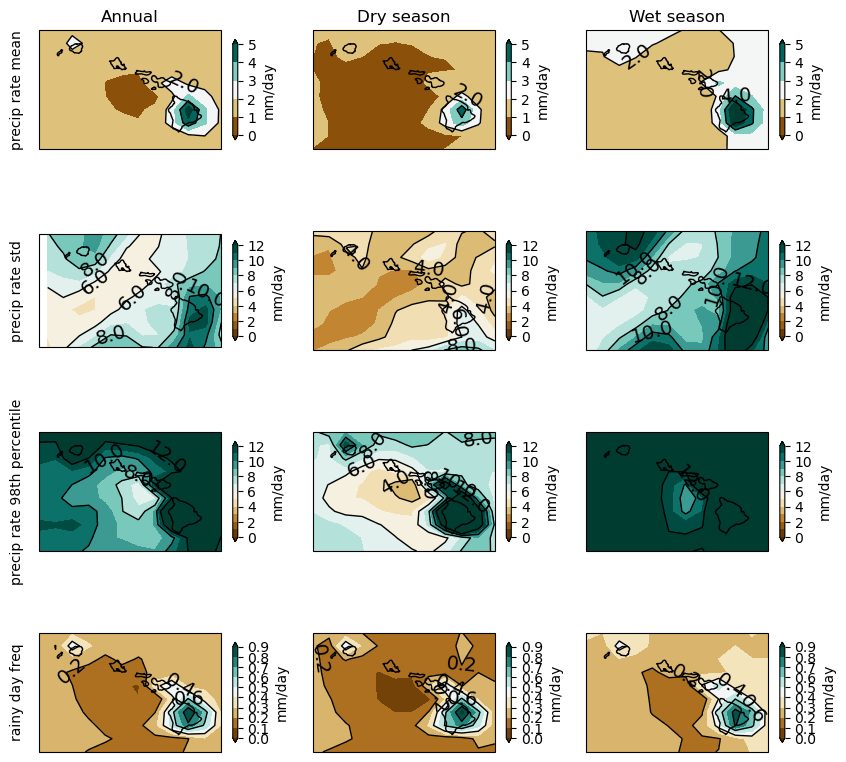

In [226]:
fig, axs = plt.subplots(4, 3, figsize=(10,10), subplot_kw=dict(projection=ccrs.PlateCarree()))
plot_contourf(ax=axs[0,0], lat=ds_gcm.lat, lon=ds_gcm.lon, data=annual_precip_rate_mean, cmap='BrBG', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[1,0], lat=ds_gcm.lat, lon=ds_gcm.lon, data=annual_precip_rate_std, cmap='BrBG', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[2,0], lat=ds_gcm.lat, lon=ds_gcm.lon, data=annual_precip_rate_98, cmap='BrBG', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[3,0], lat=ds_gcm.lat, lon=ds_gcm.lon, data=annual_rainy_day_freq, cmap='BrBG', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')

plot_contourf(ax=axs[0,1], lat=ds_gcm.lat, lon=ds_gcm.lon, data=dry_precip_rate_mean, cmap='BrBG', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[1,1], lat=ds_gcm.lat, lon=ds_gcm.lon, data=dry_precip_rate_std, cmap='BrBG', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[2,1], lat=ds_gcm.lat, lon=ds_gcm.lon, data=dry_precip_rate_98, cmap='BrBG', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[3,1], lat=ds_gcm.lat, lon=ds_gcm.lon, data=dry_rainy_day_freq, cmap='BrBG', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')

plot_contourf(ax=axs[0,2], lat=ds_gcm.lat, lon=ds_gcm.lon, data=wet_precip_rate_mean, cmap='BrBG', levels=np.arange(0, 6, 1), cbar_label='mm/day')
plot_contourf(ax=axs[1,2], lat=ds_gcm.lat, lon=ds_gcm.lon, data=wet_precip_rate_std, cmap='BrBG', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[2,2], lat=ds_gcm.lat, lon=ds_gcm.lon, data=wet_precip_rate_98, cmap='BrBG', levels=np.arange(0, 13, 1), cbar_label='mm/day')
plot_contourf(ax=axs[3,2], lat=ds_gcm.lat, lon=ds_gcm.lon, data=wet_rainy_day_freq, cmap='BrBG', levels=np.arange(0, 1, 0.1), cbar_label='mm/day')
[ax.coastlines() for ax in axs.flatten()]

axs[0,0].set_title('Annual')
axs[0,1].set_title('Dry season')
axs[0,2].set_title('Wet season')

fig.canvas.draw()
geo_ylabel(axs[0,0], 'precip rate mean')
geo_ylabel(axs[1,0], 'precip rate std')
geo_ylabel(axs[2,0], 'precip rate 98th percentile')
geo_ylabel(axs[3,0], 'rainy day freq')
pass